**1. Important downloads**

This section downloads the important libraries for our model

In [ ]:
!pip install  torch sympy

In [ ]:
!pip install magpylib
import magpylib as magpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**2. Predictions**

This section run the machine learning model with our optimized hyperparameters

In [ ]:
# This class can now specify the number of hidden layer in the neural network instead of manually creating thems
class MagneticFieldNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, numOfLayers):
        super(MagneticFieldNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = nn.ModuleList()  # Create a ModuleList to store layers

        # Add input layer
        self.layers.append(nn.Linear(input_size, hidden_size,bias=True))
        self.layers.append(nn.ReLU())


        # Add hidden layers
        for _ in range(numOfLayers - 1):  # Subtract 1 for the input layer
            self.layers.append(nn.Linear(hidden_size, hidden_size,bias=True))
            self.layers.append(nn.ReLU())

        # Add output layer
        self.layers.append(nn.Linear(hidden_size, output_size,bias=True))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
# Class to create a magnetic source (coil)
# Diameters, currents and positions can be passed as single arguments or arrays
# If passed as arrays, equivalent of several sources
# the three arguments must have the same dimensions

class MagneticSource():
  def __init__(self,diameters, currents, positions):
    self.source = []
    try:
      iter(diameters)
      iter(currents)
      iter(positions)

      for cur, dia, pos in zip(currents, diameters, positions):
        self.source.append(magpy.current.Circle(diameter=dia, current=cur, position=pos))

    except TypeError:
      self.source = magpy.current.Circle(diameter=diameters, current=currents, position=positions)


  # get the induced magnetic field at a specific point
  def get_induced_B_field(self,points):
    try:
      iter(self.source)
      B = 0
      for coil in self.source:
        if (isinstance(coil, magpy._src.obj_classes.class_current_Circle.Circle)):
          B = B + magpy.getB(coil,points)
      return B

    except TypeError:

      return magpy.getB(self.source,points)


  def add_source(self, dia, cur, pos):
    self.source.append(magpy.current.Circle(diameter=dia, current=cur, position=pos))



In [ ]:
def compute_divergence(predicted_B, grid_points):
    """Compute the divergence of the magnetic field."""
    B_x, B_y, B_z = predicted_B[:, 0], predicted_B[:, 1], predicted_B[:, 2]

    # Compute partial derivatives using finite differences
    dB_x_dx = np.gradient(B_x, grid_points[:, 0])
    dB_y_dy = np.gradient(B_y, grid_points[:, 1])
    dB_z_dz = np.gradient(B_z, grid_points[:, 2])

    divergence = dB_x_dx + dB_y_dy + dB_z_dz
    return np.mean(np.abs(divergence))

def interpolate_nans(array, grid_points):
    """Interpolate NaN values in the array."""
    nans = np.isnan(array)
    if np.any(nans):
        not_nans = np.where(~nans)[0]
        array[nans] = np.interp(np.where(nans)[0], not_nans, array[not_nans])
    return array

def compute_divergence_NAN_handling(predicted_B, grid_points):
    """Compute the divergence of the magnetic field."""
    B_x, B_y, B_z = predicted_B[:, 0], predicted_B[:, 1], predicted_B[:, 2]

    # Interpolate NaN values
    B_x = interpolate_nans(B_x, grid_points[:, 0])
    B_y = interpolate_nans(B_y, grid_points[:, 1])
    B_z = interpolate_nans(B_z, grid_points[:, 2])

    # Compute partial derivatives using finite differences
    dB_x_dx = np.gradient(B_x, grid_points[:, 0])
    dB_y_dy = np.gradient(B_y, grid_points[:, 1])
    dB_z_dz = np.gradient(B_z, grid_points[:, 2])

    # Compute divergence
    divergence = dB_x_dx + dB_y_dy + dB_z_dz
    return np.mean(np.abs(divergence))

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.base import BaseEstimator, RegressorMixin

In [ ]:
from scipy.interpolate import griddata

In [ ]:
class MagneticFieldNN_SIM(BaseEstimator, RegressorMixin):

  def __init__(self, coil, model, criterion, optimizer, training_points, num_epochs, lambda_divergence,testPoints,training_B=[],test_B=[]):

    self.training_points = training_points
    fieldVector = []
    if coil is None:

      fieldVector = training_B

    else:

      fieldVector = coil.get_induced_B_field(training_points)

    norms = np.linalg.norm(fieldVector, axis=1)
    fieldDirection = fieldVector/norms[:, np.newaxis]

    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    self.num_epochs = num_epochs
    self.lambda_divergence = lambda_divergence
    self.Xs = torch.tensor(training_points, dtype=torch.float32)
    self.Ys = torch.tensor(fieldDirection, dtype=torch.float32)
    self.coil = coil


    self.testPoints = testPoints

    testVector = []

    if coil is None:

      testVector = test_B

    else:

      testVector = coil.get_induced_B_field(testPoints)


    testNorms = np.linalg.norm(testVector, axis=1)
    self.testExpected = testVector/testNorms[:, np.newaxis]
    self.testXs = torch.tensor(testPoints, dtype=torch.float32)
    self.testYs = torch.tensor(self.testExpected, dtype=torch.float32)
    self.testPredictions = []


  def compute_divergence(self, predicted_B, grid_points):
    """Compute the divergence of the magnetic field."""
    B_x, B_y, B_z = predicted_B[:, 0], predicted_B[:, 1], predicted_B[:, 2]


    # Compute partial derivatives using finite differences
    dB_x_dx = np.gradient(B_x, grid_points[:, 0])
    dB_y_dy = np.gradient(B_y, grid_points[:, 1])
    dB_z_dz = 0



    if self.coil is not None:
      dB_z_dz = np.gradient(B_z, grid_points[:, 2])



    divergence = dB_x_dx + dB_y_dy + dB_z_dz

    num_nan = np.isnan(divergence).sum()

    if(num_nan>0):

      divergence = self.compute_divergence_NAN_handling(predicted_B,grid_points)


    return np.mean(np.abs(divergence))




  def interpolate_nans_2d(self,data, grid_points):
    """
    Interpolate NaN values in a 2D or 3D array using griddata.
    """
    nans = np.isnan(data)
    if np.any(nans):
        # Get valid points and their corresponding values
        valid_points = grid_points[~nans]
        valid_values = data[~nans]

        # Interpolate the missing values
        data[nans] = griddata(
            valid_points, valid_values, grid_points[nans], method='linear', fill_value=0
        )
    return data

  def compute_divergence_NAN_handling(self,predicted_B, grid_points):
    """
    Compute the divergence of the magnetic field with improved NaN handling.
    """
    # Separate components of the magnetic field
    B_x, B_y, B_z = predicted_B[:, 0], predicted_B[:, 1], predicted_B[:, 2]

    # Compute partial derivatives using finite differences
    dB_x_dx = np.gradient(B_x, grid_points[:, 0])
    dB_y_dy = np.gradient(B_y, grid_points[:, 1])
    dB_z_dz = 0

    # # Interpolate NaN values using griddata
    # B_x = self.interpolate_nans_2d(B_x, grid_points)
    # B_y = self.interpolate_nans_2d(B_y, grid_points)
    # B_z = self.interpolate_nans_2d(B_z, grid_points)

    # # Reshape grid points for structured finite differences
    # x = grid_points[:, 0]
    # y = grid_points[:, 1]
    # z = grid_points[:, 2]

    # # Compute gradients with central differences
    # dB_x_dx = np.gradient(B_x, x, edge_order=2)
    # dB_y_dy = np.gradient(B_y, y, edge_order=2)
    # dB_z_dz = np.gradient(B_z, z, edge_order=2)

    # Compute divergence
    divergence = dB_x_dx + dB_y_dy + dB_z_dz

    cleared_divergence = divergence[~np.isnan(divergence)]
    cleared_divergence = cleared_divergence[np.isfinite(cleared_divergence)]

    # print(f'dB_x_dx : {dB_x_dx}')
    # print(f'dB_y_dy : {dB_y_dy}')
    # print(f'dB_z_dz : {dB_z_dz}')
    # print(f'divergence: {divergence}')
    # print(f'cleared divergence: {cleared_divergence}')
    # print(f'absolute divergence: {np.abs(cleared_divergence)}')
    # print(f'MAPE: {np.mean(np.abs(cleared_divergence))}')

    # i = 0;
    # for div in np.abs(cleared_divergence):
    #    if i < 400:
    #     print(f'value {i}: {div}')
    #    i = i + 1


    # # Handle NaN divergence values if they still occur (as fallback)
    # if np.any(np.isnan(divergence)):
    #     divergence = np.nan_to_num(divergence, nan=0.0)

    return np.mean(np.abs(cleared_divergence))





  def fit(self):

    self.model.train() # Set the model in training mode
    for epoch in range(self.num_epochs):
      # Forward pass
      outputs = self.model(self.Xs)

      # Compute divergence penalty
      divergence_penalty = self.compute_divergence(outputs.detach().numpy(), self.training_points)

      # Compute loss
      loss = self.criterion(outputs, self.Ys) + self.lambda_divergence * divergence_penalty

      if (loss <= 0.0015):
        break

      # Backward pass and optimization
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Print loss for monitoring training progress
      print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {loss.item():.4f}')

      # Print loss for monitoring training progress
      print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {loss.item():.4f}')


  def predict(self):
    # Test set
    self.model.eval()
    with torch.no_grad():
      self.testPredictions = self.model(self.testXs)


  def get_params(self,deep=True):

    return {

            'input_size': self.model.input_size,
            'hidden_size': self.model.hidden_size,
            'output_size': self.model.output_size,
            'learning_rate': self.optimizer.param_groups[0]['lr'],
            'epochs': self.num_epochs

    }


  def set_params(self, **params):
        # Set the model's parameters (hyperparameters)
        for param, value in params.items():
            setattr(self, param, value)
        return self












In [ ]:
import scipy.constants as const

In [ ]:
# Validation set
np.random.seed(25)
numberOfSamples = 2500
validation_points = np.random.rand(numberOfSamples, 3) * 2 - 1

In [ ]:
# Model with data simulated using maglib.py (python)

# coil
current = 0.1
coil_diameter = 0.25
coil = MagneticSource(current,coil_diameter,(0,0,0))


# model
input_size = 3
hidden_size = 30
output_size = 3
numOfLayers = 4
model = MagneticFieldNN(input_size,hidden_size,output_size,numOfLayers)


# Criterion
criterion = nn.MSELoss()


# Optimizer
learning_rate = 0.00985
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training set
np.random.seed(26)
numberOfSamples = 100000
training_points = np.random.rand(numberOfSamples, 3) * 2 - 1



# Test Set
numberOfTests = 1000
np.random.seed(27)
testPoints = np.random.rand(numberOfTests, 3) * 2 - 1


# Training
num_epochs = 850
#num_epochs = 1
lambda_divergence = 0.0015

PINN_SIM_DATA = MagneticFieldNN_SIM(coil, model, criterion, optimizer, training_points, num_epochs, lambda_divergence,testPoints)
PINN_SIM_DATA.fit()


# Test set
testExpected = PINN_SIM_DATA.testExpected
testXs = PINN_SIM_DATA.testXs
testYs = PINN_SIM_DATA.testYs


# Prediction
PINN_SIM_DATA.predict()
testPredictions = PINN_SIM_DATA.testPredictions



Epoch [1/850], Loss: 0.3397
Epoch [1/850], Loss: 0.3397
Epoch [2/850], Loss: 0.3306
Epoch [2/850], Loss: 0.3306
Epoch [3/850], Loss: 0.3259
Epoch [3/850], Loss: 0.3259
Epoch [4/850], Loss: 0.3232
Epoch [4/850], Loss: 0.3232
Epoch [5/850], Loss: 0.3187
Epoch [5/850], Loss: 0.3187
Epoch [6/850], Loss: 0.3122
Epoch [6/850], Loss: 0.3122
Epoch [7/850], Loss: 0.3042
Epoch [7/850], Loss: 0.3042
Epoch [8/850], Loss: 0.2933
Epoch [8/850], Loss: 0.2933
Epoch [9/850], Loss: 0.2807
Epoch [9/850], Loss: 0.2807
Epoch [10/850], Loss: 0.2669
Epoch [10/850], Loss: 0.2669
Epoch [11/850], Loss: 0.2521
Epoch [11/850], Loss: 0.2521
Epoch [12/850], Loss: 0.2393
Epoch [12/850], Loss: 0.2393
Epoch [13/850], Loss: 0.2322
Epoch [13/850], Loss: 0.2322
Epoch [14/850], Loss: 0.2257
Epoch [14/850], Loss: 0.2257
Epoch [15/850], Loss: 0.2149
Epoch [15/850], Loss: 0.2149
Epoch [16/850], Loss: 0.2028
Epoch [16/850], Loss: 0.2028
Epoch [17/850], Loss: 0.1885
Epoch [17/850], Loss: 0.1885
Epoch [18/850], Loss: 0.1793
Epo

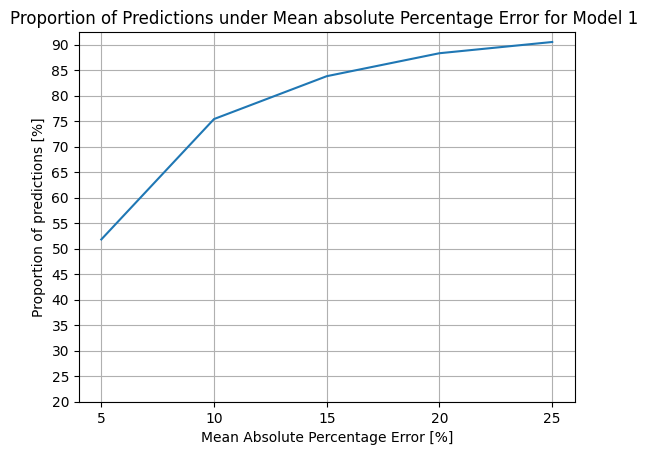

In [ ]:
# Test accuracy
meanTestYs = torch.mean(testYs)

tss = torch.sum((testYs - meanTestYs)**2)


rss = torch.sum((testYs - testPredictions)**2)


rSquared = 1 - (rss / tss)
absolutePercentageError = np.abs((testExpected - testPredictions.numpy()) / testExpected) * 100
absolutePercentageError[np.isnan(absolutePercentageError)] = 0
mape = np.mean(absolutePercentageError, axis=1)

errorPercentage = np.arange(5, 26, 5)
NbUnderPercentage = np.array([np.sum(mape <= x) for x in errorPercentage])

#print(f'mape: {mape}')
plt.plot(errorPercentage, NbUnderPercentage/numberOfTests * 100)
plt.xticks(errorPercentage)
plt.yticks(np.arange(20, 91, 5))

plt.xlabel('Mean Absolute Percentage Error [%]')
plt.ylabel('Proportion of predictions [%]')
plt.title('Proportion of Predictions under Mean absolute Percentage Error for Model 1 ')

plt.grid(True)
plt.show()

In [ ]:
# Get Training Set
ts1_df = pd.read_csv('/content/gdrive/MyDrive/trainingSet1_v2.csv',names = ['x','y','Hx','Hy'])
ts2_df = pd.read_csv('/content/gdrive/MyDrive/trainingSet2_v2.csv',names = ['x','y','Hx','Hy'])
training_set_df = pd.concat([ts1_df, ts2_df], ignore_index=True)
training_set_df['Hz'] = np.zeros(len(training_set_df))
training_set_df['z'] = np.zeros(len(training_set_df))

training_datapoints = training_set_df[['x','y','z']].to_numpy()
training_B =  training_set_df[['Hx','Hy','Hz']].to_numpy()*const.mu_0

# Get Validation Set
val_and_test_set_df = pd.read_csv('/content/gdrive/MyDrive/validationSet_v2.csv',names = ['x','y','Hx','Hy'])
val_and_test_set_df['Hz'] = np.zeros(len(val_and_test_set_df))
val_and_test_set_df['z'] = np.zeros(len(val_and_test_set_df))
validation_set_df = val_and_test_set_df.iloc[:len(val_and_test_set_df) // 2]

validation_datapoints = validation_set_df[['x','y','z']].to_numpy()
validation_B = validation_set_df[['Hx','Hy','Hz']].to_numpy()*const.mu_0


# Get Test Set
test_set_df = val_and_test_set_df.iloc[len(val_and_test_set_df) // 2:]
test_set_df = test_set_df.iloc[:].reset_index(drop=True)

test_datapoints = test_set_df[['x','y','z']].to_numpy()
test_B = test_set_df[['Hx','Hy','Hz']].to_numpy()*const.mu_0


In [ ]:
# Model with data simulated using Magnet
# model
input_size = 3
hidden_size = 30
output_size = 3
numOfLayers = 4
model = MagneticFieldNN(input_size,hidden_size,output_size,numOfLayers)

# Criterion
criterion = nn.MSELoss()
# Optimizer
learning_rate = 0.00985
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 850

lambda_divergence = 0.0015
# Training
PINN_MAGNET_DATA = MagneticFieldNN_SIM(None,model, criterion, optimizer,training_datapoints,num_epochs,lambda_divergence,test_datapoints,training_B, test_B)
PINN_MAGNET_DATA.fit()

# Test Set
testExpected = PINN_MAGNET_DATA.testExpected
testXs = PINN_MAGNET_DATA.testXs
numberOfTests = len(testXs)

testYs = PINN_MAGNET_DATA.testYs

# Prediction
PINN_MAGNET_DATA.predict()
testPredictions = PINN_MAGNET_DATA.testPredictions
testPredictions[:,-1] = 0


<ipython-input-90-87997fd5f6cf>:11: RuntimeWarning: invalid value encountered in divide
  absolutePercentageError = np.abs((testExpected - testPredictions.numpy()) / testExpected) * 100


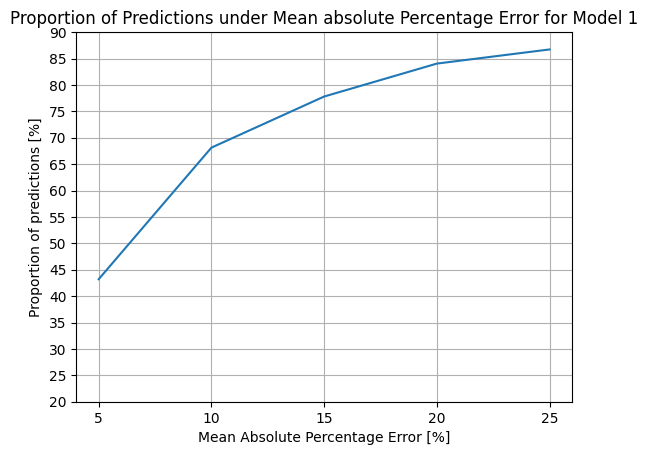

In [ ]:
# Test accuracy
meanTestYs = torch.mean(testYs)

tss = torch.sum((testYs - meanTestYs)**2)


rss = torch.sum((testYs - testPredictions)**2)


rSquared = 1 - (rss / tss)
absolutePercentageError = np.abs((testExpected - testPredictions.numpy()) / testExpected) * 100
absolutePercentageError[np.isnan(absolutePercentageError)] = 0
mape = np.mean(absolutePercentageError, axis=1)

errorPercentage = np.arange(5, 26, 5)
NbUnderPercentage = np.array([np.sum(mape <= x) for x in errorPercentage])

#print(f'mape: {mape}')
plt.plot(errorPercentage, NbUnderPercentage/numberOfTests * 100)
plt.xticks(errorPercentage)
plt.yticks(np.arange(20, 91, 5))

plt.xlabel('Mean Absolute Percentage Error [%]')
plt.ylabel('Proportion of predictions [%]')
plt.title('Proportion of Predictions under Mean absolute Percentage Error for Model 2')

plt.grid(True)

plt.show()




In [ ]:
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

# Cross-validation function
def cross_validate_model(num_folds, model_class, training_points, coil, criterion, optimizer_cls, num_epochs, lambda_divergence,B_points=[]):
    """
    Perform k-fold cross-validation on the MagneticFieldNN_SIM model.
    """
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(training_points)):
        # Split data into training and validation sets for this fold
        X_train, X_val = training_points[train_idx], training_points[val_idx]


        if(coil is not None):
          # Generate training and validation magnetic fields
          y_train = coil.get_induced_B_field(X_train)
          y_val = coil.get_induced_B_field(X_val)

        else:

          y_train = B_points[train_idx]
          y_val = B_points[val_idx]


        # Initialize model and optimizer for this fold
        model = MagneticFieldNN(input_size=3, hidden_size=30, output_size=3, numOfLayers=4)
        optimizer = optimizer_cls(model.parameters(), lr=learning_rate)

        # Create MagneticFieldNN_SIM instance for this fold
        fold_model = model_class(
            coil=coil,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            training_points=X_train,
            num_epochs=num_epochs,
            lambda_divergence=lambda_divergence,
            testPoints=X_val,
            training_B = y_train,
            test_B = y_val

        )

        # Train model on this fold's training data
        fold_model.fit()

        # Predict on validation set
        fold_model.predict()
        predictions = fold_model.testPredictions.detach().numpy()
        y_val_actual = y_val / np.linalg.norm(y_val, axis=1)[:, np.newaxis]  # Normalize expected values

        # Calculate MAPE for this fold
        fold_score = mean_absolute_percentage_error(y_val_actual, predictions)
        scores.append(fold_score)
        print(f"Fold {fold + 1} - MAPE: {fold_score:.4f}")

    # Average score across all folds
    avg_score = np.mean(scores)
    print(f"Average MAPE across {num_folds} folds: {avg_score:.4f}")
    return avg_score

In [ ]:
# Parameters for cross-validation
num_folds = 5
learning_rate = 0.00985
num_epochs = 850
lambda_divergence = 0.0015
# Perform cross-validation for model with data from maglib.py
# average_mape = cross_validate_model(
#     num_folds=num_folds,
#     model_class=MagneticFieldNN_SIM,
#     training_points=validation_points,
#     coil=coil,
#     criterion=criterion,
#     optimizer_cls=optim.Adam,
#     num_epochs=num_epochs,
#     lambda_divergence=lambda_divergence
# )

# print(f"Average MAPE from Cross-Validation for Model 1: {average_mape:.4f}")

average_mape = cross_validate_model(
    num_folds=num_folds,
    model_class=MagneticFieldNN_SIM,
    training_points=validation_datapoints,
    coil=None,
    criterion=criterion,
    optimizer_cls=optim.Adam,
    num_epochs=num_epochs,
    lambda_divergence=lambda_divergence,
    B_points=validation_B

)


print(f"Final Average MAPE from Cross-Validation for Model 2: {average_mape:.4f}")

Epoch [1/850], Loss: 7.6642
Epoch [1/850], Loss: 7.6642
Epoch [2/850], Loss: 1.4344
Epoch [2/850], Loss: 1.4344
Epoch [3/850], Loss: 0.9513
Epoch [3/850], Loss: 0.9513
Epoch [4/850], Loss: 0.6085
Epoch [4/850], Loss: 0.6085
Epoch [5/850], Loss: 0.4370
Epoch [5/850], Loss: 0.4370
Epoch [6/850], Loss: 0.2594
Epoch [6/850], Loss: 0.2594
Epoch [7/850], Loss: 0.1651
Epoch [7/850], Loss: 0.1651
Epoch [8/850], Loss: 0.1378
Epoch [8/850], Loss: 0.1378
Epoch [9/850], Loss: 0.1323
Epoch [9/850], Loss: 0.1323
Epoch [10/850], Loss: 0.1232
Epoch [10/850], Loss: 0.1232
Epoch [11/850], Loss: 0.1060
Epoch [11/850], Loss: 0.1060
Epoch [12/850], Loss: 0.0947
Epoch [12/850], Loss: 0.0947
Epoch [13/850], Loss: 0.0926
Epoch [13/850], Loss: 0.0926
Epoch [14/850], Loss: 0.0816
Epoch [14/850], Loss: 0.0816
Epoch [15/850], Loss: 0.0659
Epoch [15/850], Loss: 0.0659
Epoch [16/850], Loss: 0.0600
Epoch [16/850], Loss: 0.0600
Epoch [17/850], Loss: 0.0586
Epoch [17/850], Loss: 0.0586
Epoch [18/850], Loss: 0.0594
Epo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * d

In [ ]:
# Save the weights of the training
parameters = list(model.parameters())
weights = [param for param in parameters if len(param.shape) > 1]
for i, weight in enumerate(weights):
    print(f"Weight {i + 1}:")
    print(weight.shape)
print(np.linalg.norm(testPredictions, axis=1))

Weight 1:
torch.Size([30, 3])
Weight 2:
torch.Size([30, 30])
Weight 3:
torch.Size([30, 30])
Weight 4:
torch.Size([30, 30])
Weight 5:
torch.Size([3, 30])
[1.2022234  1.0197607  0.9830073  ... 0.97417164 1.0648162  1.0113094 ]


This section tests the effect of different hyperparameter values on the overall accuracy. **Don't run this section !!!!**

In [ ]:
# Single magnetomotive force
# Algorithm with optimized hyperparameters
numberOfSamples = 100000
coil_diameter = 0.05
points = np.random.rand(numberOfSamples, 3) * 2 - 1
coil = MagneticSource(0.1,coil_diameter,(0,0,0))
fieldVector = coil.get_induced_B_field(points)
norms = np.linalg.norm(fieldVector, axis=1)
fieldDirection = fieldVector/norms[:, np.newaxis]
print(fieldVector[1])
print(np.linalg.norm(fieldVector[1]))
print(np.linalg.norm(fieldDirection[1]))


learning_rates = [0.00955,0.00970,0.00985,0.01,0.0115]
lambdas = [0.0005,0.0010,0.0015,0.0020,0.0025]
hidden_sizes = [5,10,20,26,30]
number_hidden_layers = [2,3,4,5,6]
testPredictions_list = []
testYs_list = []
for lbda in lambdas:
    model = MagneticFieldNN(3,26,3,4)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00985)
    Xs = torch.tensor(points, dtype=torch.float32)
    Ys = torch.tensor(fieldDirection, dtype=torch.float32)

    # Train set
    num_epochs = 850
    model.train() # Set the model in training mode
    lambda_divergence = lbda
    for epoch in range(num_epochs):
      # Forward pass
      outputs = model(Xs)

      # Compute divergence penalty
      divergence_penalty = compute_divergence(outputs.detach().numpy(), points)

      # Compute loss
      loss = criterion(outputs, Ys) + lambda_divergence * divergence_penalty
      #loss = criterion( outputs, Ys)
      if (loss <= 0.0015):
        break

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print loss for monitoring training progress
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Test set
    numberOfTests = 1000
    testPoints = np.random.rand(numberOfTests, 3) * 2 - 1
    testVector = coil.get_induced_B_field(testPoints)
    testNorms = np.linalg.norm(testVector, axis=1)
    testExpected = testVector/testNorms[:, np.newaxis]

    testXs = torch.tensor(testPoints, dtype=torch.float32)
    testYs_list.append(torch.tensor(testExpected, dtype=torch.float32))
    model.eval()


    with torch.no_grad():
      testPredictions_list.append(model(testXs))

In [ ]:
for lmbda,testYs,testPredictions in zip(lambdas,testYs_list,testPredictions_list):

  # Test accuracy
  meanTestYs = torch.mean(testYs)

  tss = torch.sum((testYs - meanTestYs)**2)


  rss = torch.sum((testYs - testPredictions)**2)


  rSquared = 1 - (rss / tss)
  absolutePercentageError = np.abs((testExpected - testPredictions.numpy()) / testExpected) * 100
  absolutePercentageError[np.isnan(absolutePercentageError)] = 0
  mape = np.mean(absolutePercentageError, axis=1)

  errorPercentage = np.arange(5, 26, 5)
  NbUnderPercentage = np.array([np.sum(mape <= x) for x in errorPercentage])

  #print(f'mape: {mape}')
  plt.plot(errorPercentage, NbUnderPercentage/numberOfTests * 100)

  plt.xticks(errorPercentage)
  print(lmbda)
  print(errorPercentage)
  print(NbUnderPercentage/numberOfTests * 100)
  plt.yticks(np.arange(20, 91, 5))

  plt.xlabel('Mean Absolute Percentage Error [%]')
  plt.ylabel('Proportion of predictions [%]')
  plt.title('Proportion of Predictions under Mean absolute Percentage Error')

  plt.grid(True)

  plt.show()


**Do not run the following cells!!!!!**

It was designed to find the optimal hyperparameters based on an algorithm.
It takes a long time to run so we only ran it once to find our hyperparameters

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [ ]:
# Find optimal hyperparameters

numberOfSamples = 100000
points = np.random.rand(numberOfSamples, 3) * 2 - 1
fieldVector = magpy.getB(coil, points)

# direction
norms = np.linalg.norm(fieldVector, axis=1)
fieldDirection = fieldVector / norms[:, np.newaxis]

#for n in numberOfHiddenLayers:
@use_named_args([Real(0.001, 0.01, name='learning_rate'),
                 Integer(1, 8, name='num_hidden_layers'),
                 Integer(5, 30, name='size_hidden_layers')])
def objective(learning_rate, num_hidden_layers, size_hidden_layers):
  model = MagneticFieldNN(3,size_hidden_layers,3,num_hidden_layers)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  Xs = torch.tensor(points, dtype=torch.float32)
  Ys = torch.tensor(fieldDirection, dtype=torch.float32)


  # Train set
  num_epochs = 2500
  model.train() # Set the model in training mode
  for epoch in range(num_epochs):
    # Forward pass
    outputs = model(Xs)
    loss = criterion(outputs, Ys)
    if (loss <= 0.0015):
      break

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print("+1")

  # Test set
  numberOfTests = 1000
  testPoints = np.random.rand(numberOfTests, 3) * 2 - 1
  testVector = magpy.getB(coil, testPoints)
  testNorms = np.linalg.norm(testVector, axis=1)
  testExpected = testVector / testNorms[:, np.newaxis]

  testXs = torch.tensor(testPoints, dtype=torch.float32)
  testYs = torch.tensor(testExpected, dtype=torch.float32)
  model.eval()


  with torch.no_grad():
    testPredictions = model(testXs)

  meanTestYs = torch.mean(testYs)

  tss = torch.sum((testYs - meanTestYs)**2)

  rss = torch.sum((testYs - testPredictions)**2)

  rSquared = 1 - (rss / tss)
  absolutePercentageError = np.abs((testExpected - testPredictions.numpy()) / testExpected) * 100
  absolutePercentageError[np.isnan(absolutePercentageError)] = 0
  mape = np.mean(absolutePercentageError, axis=1)
  errorPercentage = 15
  NbOverPercentage = np.sum(mape >= errorPercentage)

  return NbOverPercentage

space = [Real(0.001, 0.01, name='learning_rate'),
         Integer(1, 8, name='num_hidden_layers'),
         Integer(5, 30, name='size_hidden_layers')]
result = gp_minimize(objective, space, n_calls=10, random_state=42)
best_params = result.x
best_objective = result.fun
print("Best hyperparameters:", best_params)
print("Best objective:", best_objective)





+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
Best hyperparameters: [0.009849077972261096, 4, 26]
Best objective: 206
